In [220]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split


In [221]:
T = 10   # Longueur des séquences
D = 50         # Dimension des vecteurs X^t
N = 10000  

In [222]:
k = 3
V = np.random.randint(0, 2, size=(k, T)) 

In [223]:
B = V.T@V

In [224]:
B

array([[2, 1, 2, 1, 2, 1, 1, 1, 2, 0],
       [1, 1, 1, 0, 1, 0, 0, 0, 1, 0],
       [2, 1, 3, 2, 3, 1, 1, 2, 3, 1],
       [1, 0, 2, 2, 2, 1, 1, 2, 2, 1],
       [2, 1, 3, 2, 3, 1, 1, 2, 3, 1],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 0, 2, 2, 2, 1, 1, 2, 2, 1],
       [2, 1, 3, 2, 3, 1, 1, 2, 3, 1],
       [0, 0, 1, 1, 1, 0, 0, 1, 1, 1]])

In [225]:
def factorise(B, tol=1e-8):
    # Vérification symétrie
    if not np.allclose(B, B.T, atol=tol):
        raise ValueError("La matrice B n'est pas symétrique.")

    # Décomposition spectrale
    eigvals, eigvecs = np.linalg.eigh(B)

    # Vérification semi-définie positive
    if np.any(eigvals < -tol):
        raise ValueError("La matrice B n'est pas semi-définie positive.")

    # Construction de C = U Λ^{1/2}
    sqrt_eigvals = np.sqrt(np.clip(eigvals, 0, None))
    C = eigvecs @ np.diag(sqrt_eigvals)

    return C

In [226]:

def generate_X(C, N, D):
    T = C.shape[0]
    Z = np.random.randn(N, D, T)  # Z ~ N(0, I)
    X = np.einsum('ndt,ts->nds', Z, C.T)  # équivalent à batch matmul Z @ C.T
    return X

In [227]:
C = factorise(B)
X_samples = generate_X(C, N=1000, D=10)

# Estimation de E[X^T X]
B_est = np.mean([X.T @ X for X in X_samples], axis=0) / 10
print(B_est)

[[ 2.04125557e+00  1.02134184e+00  2.02642111e+00  1.00507926e+00
   2.02642111e+00  1.01991372e+00  1.01991372e+00  1.00507926e+00
   2.02642111e+00 -1.48344590e-02]
 [ 1.02134184e+00  1.01606501e+00  1.01751367e+00  1.44866495e-03
   1.01751367e+00  5.27683437e-03  5.27683439e-03  1.44866490e-03
   1.01751367e+00 -3.82816926e-03]
 [ 2.02642111e+00  1.01751367e+00  3.00503491e+00  1.98752123e+00
   3.00503491e+00  1.00890743e+00  1.00890743e+00  1.98752123e+00
   3.00503491e+00  9.78613799e-01]
 [ 1.00507926e+00  1.44866495e-03  1.98752123e+00  1.98607257e+00
   1.98752123e+00  1.00363060e+00  1.00363060e+00  1.98607257e+00
   1.98752123e+00  9.82441969e-01]
 [ 2.02642111e+00  1.01751367e+00  3.00503491e+00  1.98752123e+00
   3.00503491e+00  1.00890743e+00  1.00890743e+00  1.98752123e+00
   3.00503491e+00  9.78613800e-01]
 [ 1.01991372e+00  5.27683437e-03  1.00890743e+00  1.00363060e+00
   1.00890743e+00  1.01463689e+00  1.01463689e+00  1.00363060e+00
   1.00890743e+00 -1.10062895e-02

In [228]:
def compute_moments(B, T_max):
    """
    Calcule (B, B^2, ..., B^T_max) et les normalise (norme Frobenius)
    """
    moments = [B]
    for _ in range(1, T_max):
        moments.append(moments[-1] @ B)

    # Normalisation par norme de Frobenius
    normalized = [
        M / (np.linalg.norm(M, ord='fro') + 1e-8) for M in moments
    ]
    return np.stack(normalized, axis=0)  # shape (T_max, T, T)


In [229]:
print(compute_moments(B, T_max=4))

[[[0.13333333 0.06666667 0.13333333 0.06666667 0.13333333 0.06666667
   0.06666667 0.06666667 0.13333333 0.        ]
  [0.06666667 0.06666667 0.06666667 0.         0.06666667 0.
   0.         0.         0.06666667 0.        ]
  [0.13333333 0.06666667 0.2        0.13333333 0.2        0.06666667
   0.06666667 0.13333333 0.2        0.06666667]
  [0.06666667 0.         0.13333333 0.13333333 0.13333333 0.06666667
   0.06666667 0.13333333 0.13333333 0.06666667]
  [0.13333333 0.06666667 0.2        0.13333333 0.2        0.06666667
   0.06666667 0.13333333 0.2        0.06666667]
  [0.06666667 0.         0.06666667 0.06666667 0.06666667 0.06666667
   0.06666667 0.06666667 0.06666667 0.        ]
  [0.06666667 0.         0.06666667 0.06666667 0.06666667 0.06666667
   0.06666667 0.06666667 0.06666667 0.        ]
  [0.06666667 0.         0.13333333 0.13333333 0.13333333 0.06666667
   0.06666667 0.13333333 0.13333333 0.06666667]
  [0.13333333 0.06666667 0.2        0.13333333 0.2        0.06666667
   

In [230]:

def generate_dataset(N, D, T):

    B_true = B
    # Factorisation pour générer X
    C = factorise(B_true)
    X_samples = generate_X(C, N, D)

    # Création de (X, y)
    X_data = X_samples
    y_data = np.array([compute_moments(X.T @ X / D, T) for X in X_samples])  # normalisé

    return X_data, y_data

In [231]:
X_data, y_data = generate_dataset(N=1000, D=10, T=4)
B_est_mean = y_data[:, 0].mean(axis=0)  # moment 1 moyen
print("Différence moyenne :")
print(np.round(B_est_mean - B, 3))

Différence moyenne :
[[-1.868 -0.932 -1.874 -0.941 -1.874 -0.936 -0.936 -0.941 -1.874 -0.006]
 [-0.932 -0.928 -0.935 -0.007 -0.935 -0.004 -0.004 -0.007 -0.935 -0.003]
 [-1.874 -0.935 -2.81  -1.875 -2.81  -0.938 -0.938 -1.875 -2.81  -0.936]
 [-0.941 -0.007 -1.875 -1.867 -1.875 -0.934 -0.934 -1.867 -1.875 -0.933]
 [-1.874 -0.935 -2.81  -1.875 -2.81  -0.938 -0.938 -1.875 -2.81  -0.936]
 [-0.936 -0.004 -0.938 -0.934 -0.938 -0.932 -0.932 -0.934 -0.938 -0.003]
 [-0.936 -0.004 -0.938 -0.934 -0.938 -0.932 -0.932 -0.934 -0.938 -0.003]
 [-0.941 -0.007 -1.875 -1.867 -1.875 -0.934 -0.934 -1.867 -1.875 -0.933]
 [-1.874 -0.935 -2.81  -1.875 -2.81  -0.938 -0.938 -1.875 -2.81  -0.936]
 [-0.006 -0.003 -0.936 -0.933 -0.936 -0.003 -0.003 -0.933 -0.936 -0.931]]


In [232]:

X, y = generate_dataset(N, D, T)

print("X.shape :", X.shape)  # (N, D, T)
print("y.shape :", y.shape)  # (N, T * T * T)


X.shape : (10000, 50, 10)
y.shape : (10000, 10, 10, 10)


In [233]:
y_B = y[:,0,:,:]
print(y_B.mean(axis=0))

[[ 0.13350695  0.06711732  0.13201234  0.06489501  0.13201234  0.06638963
   0.06638963  0.06489501  0.13201234 -0.00149462]
 [ 0.06711732  0.06802693  0.06645672 -0.00157021  0.06645672 -0.0009096
  -0.0009096  -0.00157021  0.06645672 -0.00066061]
 [ 0.13201234  0.06645672  0.19825764  0.13180093  0.19825764  0.06555562
   0.06555562  0.13180093  0.19825764  0.06624531]
 [ 0.06489501 -0.00157021  0.13180093  0.13337113  0.13180093  0.06646522
   0.06646522  0.13337113  0.13180093  0.06690591]
 [ 0.13201234  0.06645672  0.19825764  0.13180093  0.19825764  0.06555562
   0.06555562  0.13180093  0.19825764  0.06624531]
 [ 0.06638963 -0.0009096   0.06555562  0.06646522  0.06555562  0.06729923
   0.06729923  0.06646522  0.06555562 -0.00083401]
 [ 0.06638963 -0.0009096   0.06555562  0.06646522  0.06555562  0.06729923
   0.06729923  0.06646522  0.06555562 -0.00083401]
 [ 0.06489501 -0.00157021  0.13180093  0.13337113  0.13180093  0.06646522
   0.06646522  0.13337113  0.13180093  0.06690591]
 

In [234]:
class MomentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [235]:
X, y = generate_dataset(N, D, T)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = MomentDataset(X_train, y_train)
test_dataset  = MomentDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [236]:
class MomentTransformer(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward, T):
        super().__init__()
        self.T = T

        # Embedding linéaire initial (projeté à d_model)
        self.input_proj = nn.Linear(d_model, d_model)

        # Encodage de position appris
        self.pos_embedding = nn.Parameter(torch.randn(1, T, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Projection vers une matrice T x T pour chaque moment (T moments au total)
        self.output_proj = nn.Linear(d_model, T * T * T)

    def forward(self, x):
        # x: (batch_size, D, T)
        x = x.permute(0, 2, 1)  # -> (batch_size, T, D)
        x = self.input_proj(x)  # -> (batch_size, T, d_model)

        # Ajout du positional embedding
        x = x + self.pos_embedding  # broadcasting sur batch

        # Passage dans le Transformer
        x = self.transformer(x)  # (batch_size, T, d_model)

        # Moyenne globale ou moyenne sur les positions
        x_pooled = x.mean(dim=1)  # (batch_size, d_model)

        # Projection finale
        y_hat = self.output_proj(x_pooled)  # (batch_size, T*T*T)
        y_hat = y_hat.view(-1, self.T, self.T, self.T)  # reshape en tenseur de moments

        return y_hat


In [251]:
model = MomentTransformer(
    d_model=D,     # correspond à la dimension des vecteurs d'entrée
    nhead=1,
    num_layers=1,
    dim_feedforward=32,
    T=T
)


In [252]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [253]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()

    return total_loss / len(dataloader)


In [254]:
def train(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    train_loss_list = []
    test_loss_list = []
    model.to(device)
    for epoch in range(num_epochs):
        test_loss = evaluate(model, test_loader, device)
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)


        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    
    return train_loss_list, test_loss_list

In [255]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

train_loss_list, test_loss_list = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device=device)


Epoch 1/10, Train Loss: 0.0112, Test Loss: 0.1340
Epoch 2/10, Train Loss: 0.0011, Test Loss: 0.0006
Epoch 3/10, Train Loss: 0.0006, Test Loss: 0.0003
Epoch 4/10, Train Loss: 0.0004, Test Loss: 0.0002
Epoch 5/10, Train Loss: 0.0003, Test Loss: 0.0002
Epoch 6/10, Train Loss: 0.0003, Test Loss: 0.0002
Epoch 7/10, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 8/10, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 9/10, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 10/10, Train Loss: 0.0002, Test Loss: 0.0002


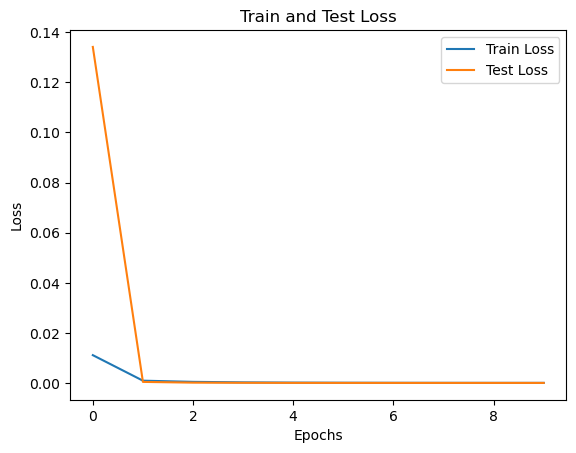

In [256]:
# plot both train and test loss
import matplotlib.pyplot as plt

def plot_loss(train_losses, test_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss')
    plt.legend()
    plt.show()

plot_loss(train_loss_list, test_loss_list)

In [257]:
model.eval()
X_sample, y_true = next(iter(test_loader))
X_sample, y_true = X_sample.to(device), y_true.to(device)
y_pred = model(X_sample)

# mean of the predictions
pred_moments = []
for i in range(T):
    pred_moments.append(y_pred[:, i, :, :].mean(dim=0).cpu().detach().numpy())

# true moments using B^k
true_moments = []
for i in range(T):
    true_moments.append(y_true[:, i, :, :].mean(dim=0).cpu().detach().numpy())


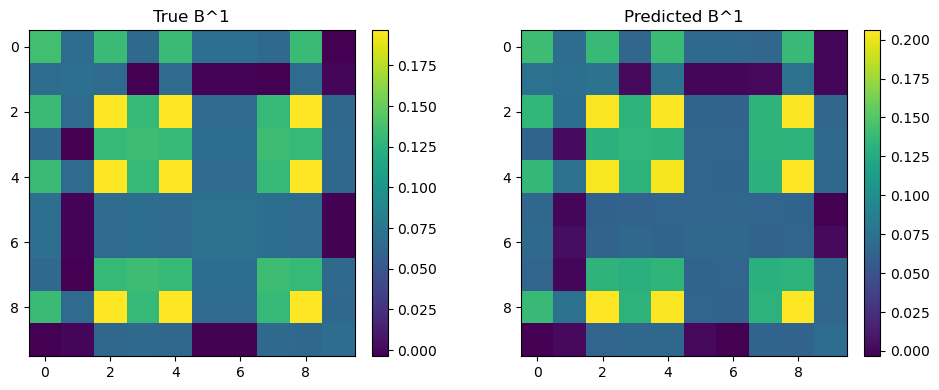

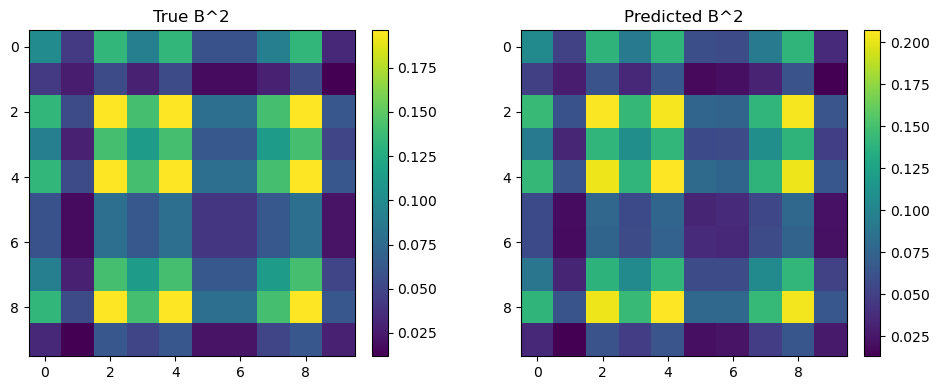

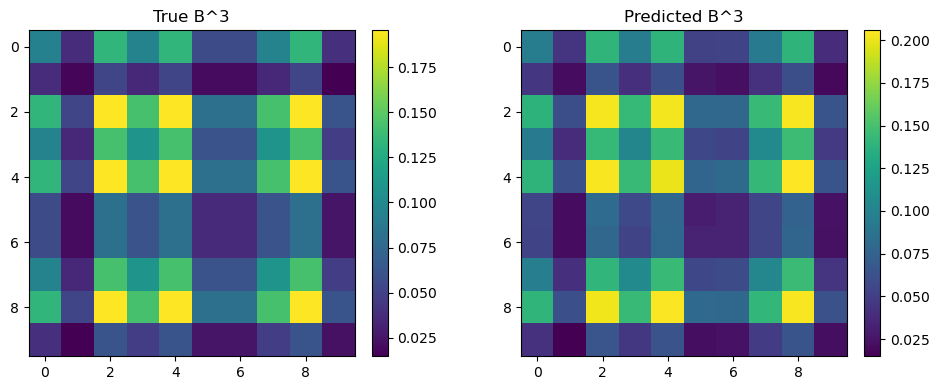

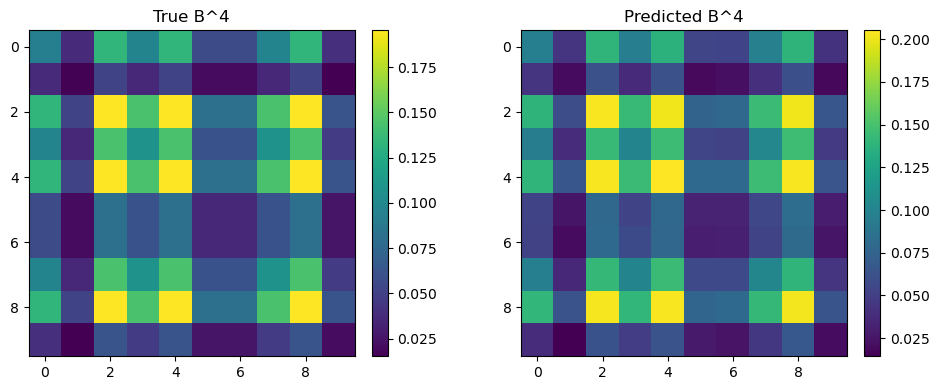

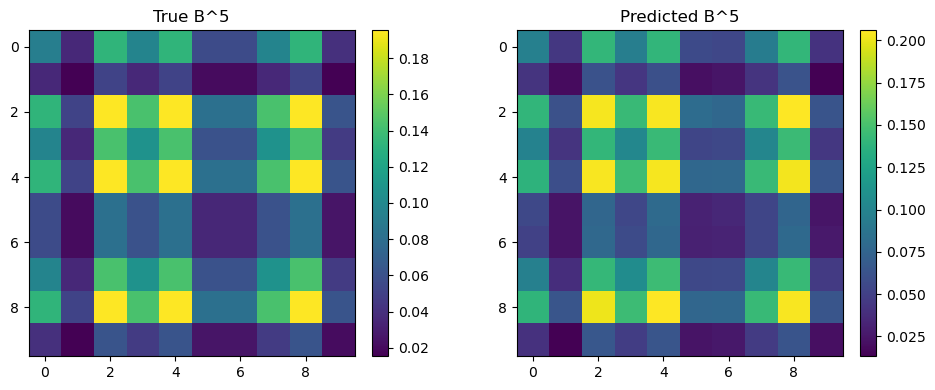

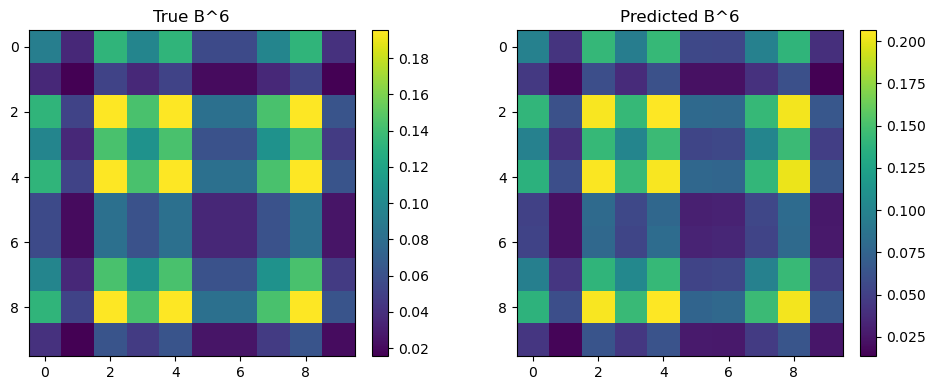

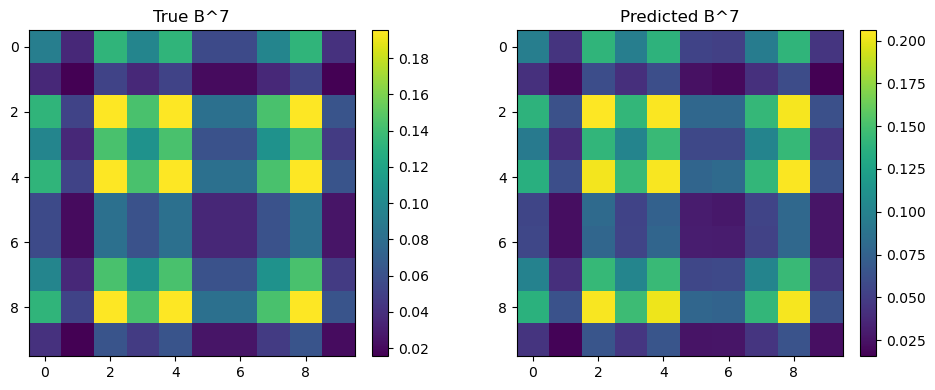

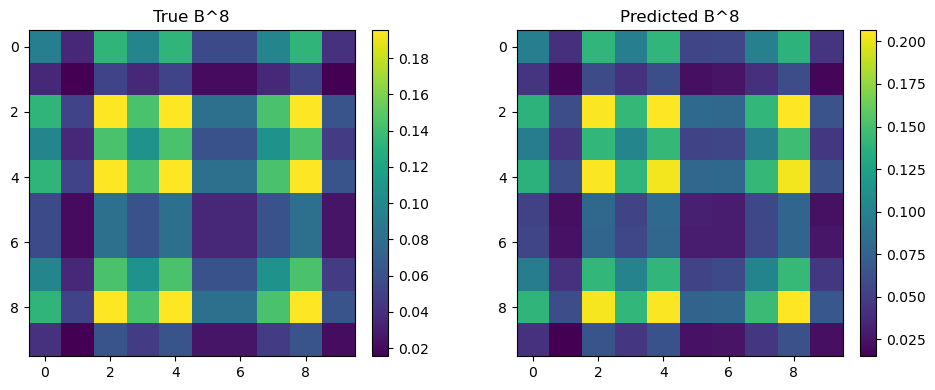

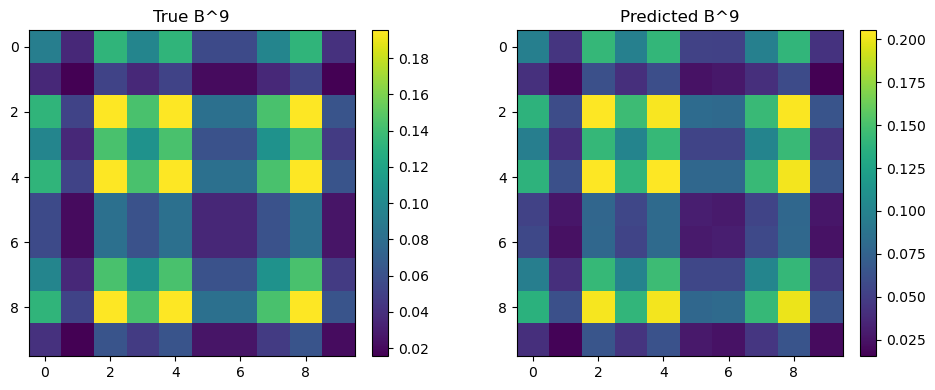

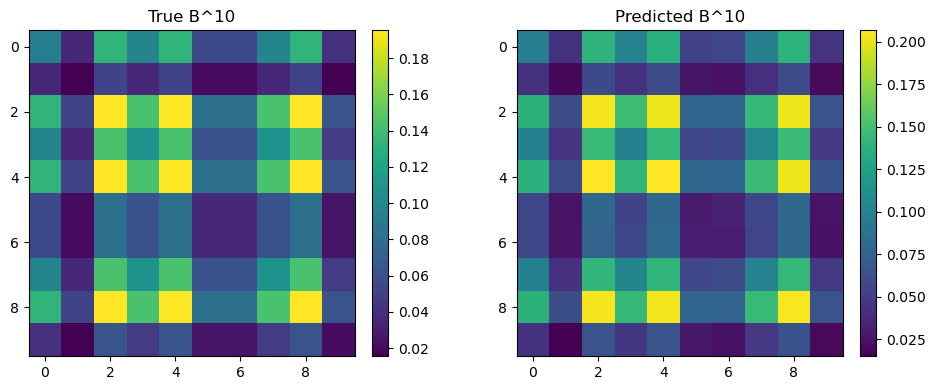

In [258]:
import matplotlib.pyplot as plt

for k in range(T):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    im0 = axes[0].imshow(true_moments[k], cmap='viridis')
    axes[0].set_title(f'True B^{k+1}')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    im1 = axes[1].imshow(pred_moments[k], cmap='viridis')
    axes[1].set_title(f'Predicted B^{k+1}')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


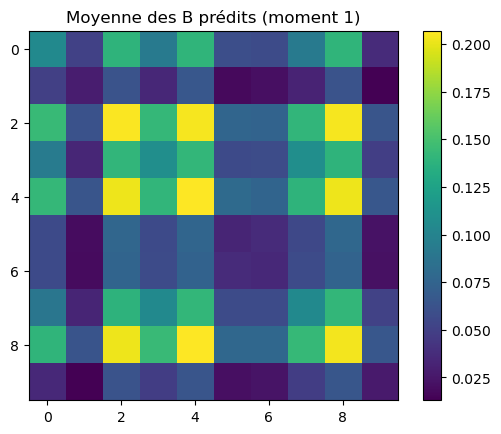

In [259]:
# Supposons que y_pred ∈ ℝ^{N, T, T, T}
# On extrait les B = y_pred[:, 0, :, :]  (le premier moment)
B_pred = y_pred[:, 1, :, :]  # (N, T, T)

# Moyenne sur le batch
B_mean = B_pred.mean(dim=0)  # (T, T)

# Si tu veux afficher la matrice ou la convertir en numpy
import matplotlib.pyplot as plt

plt.imshow(B_mean.cpu().detach().numpy(), cmap='viridis')
plt.title('Moyenne des B prédits (moment 1)')
plt.colorbar()
plt.show()


In [260]:
B_mean

tensor([[0.1047, 0.0504, 0.1391, 0.0920, 0.1402, 0.0594, 0.0576, 0.0932, 0.1401,
         0.0365],
        [0.0500, 0.0287, 0.0628, 0.0348, 0.0654, 0.0180, 0.0211, 0.0322, 0.0624,
         0.0136],
        [0.1435, 0.0620, 0.2061, 0.1419, 0.2040, 0.0761, 0.0745, 0.1405, 0.2047,
         0.0642],
        [0.0937, 0.0342, 0.1404, 0.1086, 0.1413, 0.0568, 0.0583, 0.1089, 0.1395,
         0.0493],
        [0.1424, 0.0641, 0.2020, 0.1409, 0.2070, 0.0804, 0.0752, 0.1389, 0.2018,
         0.0660],
        [0.0566, 0.0192, 0.0771, 0.0568, 0.0761, 0.0333, 0.0365, 0.0548, 0.0781,
         0.0226],
        [0.0568, 0.0187, 0.0754, 0.0572, 0.0742, 0.0367, 0.0355, 0.0576, 0.0746,
         0.0216],
        [0.0894, 0.0335, 0.1384, 0.1050, 0.1413, 0.0575, 0.0572, 0.1053, 0.1415,
         0.0515],
        [0.1402, 0.0634, 0.2023, 0.1446, 0.2065, 0.0776, 0.0777, 0.1431, 0.2037,
         0.0654],
        [0.0357, 0.0130, 0.0629, 0.0480, 0.0642, 0.0211, 0.0229, 0.0484, 0.0648,
         0.0274]], device='c

In [261]:
B

array([[2, 1, 2, 1, 2, 1, 1, 1, 2, 0],
       [1, 1, 1, 0, 1, 0, 0, 0, 1, 0],
       [2, 1, 3, 2, 3, 1, 1, 2, 3, 1],
       [1, 0, 2, 2, 2, 1, 1, 2, 2, 1],
       [2, 1, 3, 2, 3, 1, 1, 2, 3, 1],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 0, 2, 2, 2, 1, 1, 2, 2, 1],
       [2, 1, 3, 2, 3, 1, 1, 2, 3, 1],
       [0, 0, 1, 1, 1, 0, 0, 1, 1, 1]])